In [217]:
import numpy as np
import pandas as pd
from credentials import get_token
import matplotlib.pyplot as plt
from entsoe import EntsoePandasClient
from entsoe.mappings import TIMEZONE_MAPPINGS
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.compose import ReducedRegressionForecaster
from sktime.forecasting.model_selection import temporal_train_test_split, SlidingWindowSplitter, ForecastingGridSearchCV
from sktime.performance_metrics.forecasting import smape_loss, sMAPE
from sktime.utils.plotting.forecasting import plot_ys
from sklearn.linear_model import LinearRegression

country_code = 'GR'
client = EntsoePandasClient(api_key=get_token())
end = pd.Timestamp.now(tz=TIMEZONE_MAPPINGS[country_code]) - pd.DateOffset(days=15)
start = end - pd.DateOffset(months=3)
%time df = client.query_generation(country_code, start=start,end=end, psr_type=None)

Wall time: 8.6 s


In [218]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2207 entries, 2020-05-18 02:00:00+03:00 to 2020-08-18 00:00:00+03:00
Freq: 60T
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Fossil Brown coal/Lignite  2207 non-null   float64
 1   Fossil Gas                 2207 non-null   float64
 2   Fossil Oil                 2207 non-null   float64
 3   Hydro Pumped Storage       2207 non-null   float64
 4   Hydro Water Reservoir      2207 non-null   float64
 5   Solar                      2207 non-null   float64
 6   Wind Onshore               2207 non-null   float64
dtypes: float64(7)
memory usage: 137.9 KB


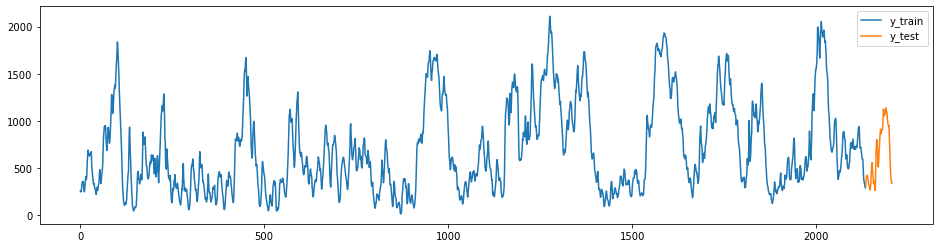

In [219]:
y = df['Wind Onshore'].reset_index(drop=True)

y_train, y_test = temporal_train_test_split(y, test_size = 72)
forecast_horizon = np.arange(y_test.shape[0]) + 1

plot_ys(y_train, y_test, labels=["y_train", "y_test"])
plt.show()

0.6497530549184962

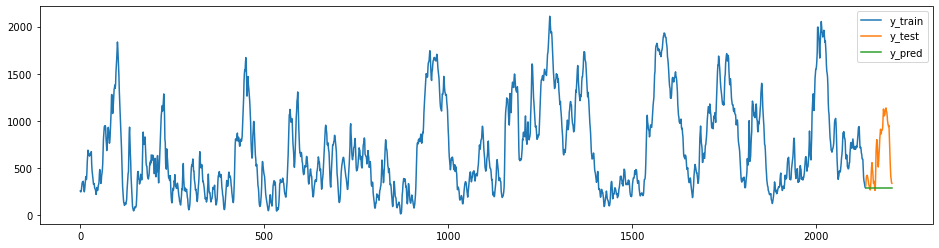

In [220]:
forecaster = NaiveForecaster(strategy="last")
forecaster.fit(y_train)
y_pred = forecaster.predict(forecast_horizon)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_pred, y_test)

Wall time: 533 ms


0.29497088516403924

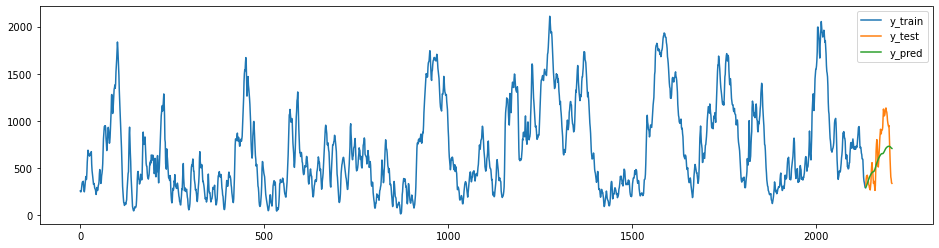

In [221]:
regressor = LinearRegression()
forecaster = ReducedRegressionForecaster(regressor=regressor, window_length=5, strategy='direct')
%time forecaster.fit(y_train, fh=forecast_horizon)
y_pred = forecaster.predict(forecast_horizon)

plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_pred, y_test)

Wall time: 7.16 s


0.3026771519370237

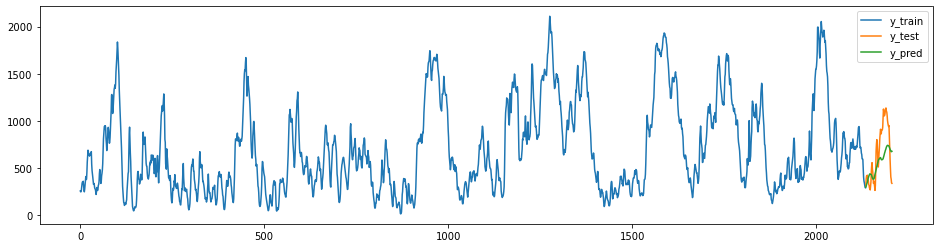

In [222]:
regressor = LinearRegression()
forecaster = ReducedRegressionForecaster(regressor=regressor, window_length=5, strategy='direct')
param_grid = {"window_length": [1, 5, 10, 15]}

cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.5))
gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=param_grid, n_jobs=8)
%time gscv.fit(y_train, fh=forecast_horizon)
y_pred = gscv.predict(forecast_horizon)

plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_pred, y_test)